# explore sketch object similarities

The purpose of this notebook is to:
* Measure how much more similar successive sketches of the SAME object are than sketches of DIFFERENT objects drawn in consecutive repetitions
* Measure how much more similar sketches of the SAME object are within a repetition (a proxy for resemblance) than arbitrarily sampled sketches from within a repetition. Examine how this similarity changes over time. 

In [1]:
import os, sys
import shutil
## add helpers to python path
if os.path.join('..','helpers') not in sys.path:
    sys.path.append(os.path.join('..','helpers'))

from embeddings import *
from extract_features import *
    
import pymongo as pm
import numpy as np
import scipy.stats as stats
import pandas as pd
import json
import requests
import re
from io import BytesIO
from PIL import Image, ImageFilter
import object_mask_utils as u
import socket
import glob
from scipy.stats import entropy
from scipy.spatial import distance_matrix

import matplotlib
from matplotlib import pylab, mlab, pyplot
%matplotlib inline
from IPython.core.pylabtools import figsize, getfigs
plt = pyplot
import seaborn as sns
sns.set_context('paper')
sns.set_style('white')

from skimage import io, img_as_float
import base64

from IPython.core.pylabtools import figsize, getfigs

from IPython.display import clear_output
import importlib
import time

from collections import Counter
import operator

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")

### setup paths

In [2]:
## which experiment do you want to analyze? options: refgame1.2, refgame2.0
curr_exp = 'refgame1.2'

## directory & file hierarchy
proj_dir = os.path.abspath('../../')
analysis_dir = os.getcwd()
data_dir = os.path.join(proj_dir,'data')
experiment_dir = os.path.join(data_dir, 'experiment', curr_exp)
feat_dir = os.path.join(data_dir, 'features', curr_exp)

## paths to visual features & metadata
path_to_feats = os.path.join(feat_dir, 'FEATURES_vgg_FC6.npy')
path_to_meta = os.path.join(feat_dir, 'METADATA.csv')

## import dictionaries that map between shapenet ids and graphical conventions naming scheme
importlib.reload(u)
G2S = u.GC2SHAPENET
S2G = u.SHAPENET2GC

## Measure how much more similar successive sketches of the SAME object are than sketches of DIFFERENT objects drawn in consecutive repetitions
To do this analysis, we either conduct a "direct" analysis addressing this question: how much more strongly drawings of Chair A "resemble" Chair A than they resemble Chair B. OR we conduct an "indirect" analysis asking how much more strongly drawings of Chair A are similar to one another than are drawings of Chair B. Further, we ask if Repetition 1 drawings display STRONGER resemblance than Repetition 8 drawings – validating the notion that resemblance goes down over time.

### DIRECT ANALYSIS (ATTEMPT TO MEASURE INSTANCE-LEVEL SKETCH-OBJECT SIMILARITY
tl;dr: we do not have sufficient resolution to resolve instance-level similarities, though we do at the "category"-level (i.e., waiting vs. dining)

#### extract VGG features for each of the object stimuli

In [3]:
## path to object images
path_to_actual_stims = os.path.join(data_dir, 'stimuli','actual')
path_to_candidate_stims = os.path.join(data_dir, 'stimuli','candidate')
stim_list_shapenet = ['{}.png'.format(i) for i in list(S2G.keys())]

## get paths of all candidate stimuli
candidate_image_paths = sorted(list_files(path_to_candidate_stims,'png'))
print('Number of candidate stimuli we originally considered: {}'.format(len(candidate_image_paths)))

## only copy over those candidate stims that were actually used in our experiment
for this_candidate_stim in candidate_image_paths:
    if this_candidate_stim.split('/')[-1] in stim_list_shapenet:
        shutil.copyfile(this_candidate_stim, os.path.join(path_to_actual_stims,this_candidate_stim.split('/')[-1]))
        
## get paths to all actual stimuli
actual_image_paths = sorted(list_files(path_to_actual_stims,'png'))
print('Number of actual stimuli we used: {}'.format(len(actual_image_paths)))

Number of candidate stimuli we originally considered: 55
Number of actual stimuli we used: 16


In [4]:
## instantiate feature extractor class
layer_name = 5
data_type = 'images'
extractor = FeatureExtractor(actual_image_paths,layer=layer_name,
                             data_type=data_type,
                             use_cuda = torch.cuda.is_available())

## extract features & metadata
features, paths = extractor.extract_feature_matrix()
meta = pd.DataFrame({'path' : list(flatten_list(paths))})

## define directory to save features out to
obj_feat_out_dir = os.path.join(data_dir, 'features','stimuli')
if not os.path.exists(obj_feat_out_dir):
    os.makedirs(obj_feat_out_dir)
features_fname = 'FEATURES_vgg_{}'.format(layer_name)

## save out features and meta
np.save(os.path.join(obj_feat_out_dir,'{}.npy'.format(features_fname)), 
        features)
meta.to_csv(os.path.join(obj_feat_out_dir,'METADATA.csv'), 
            index=True, 
            index_label='feature_ind')

print('Saved features and meta out!')
print(os.listdir(obj_feat_out_dir))

stopped!
Saved features and meta out!
['FEATURES_vgg_5.npy', 'METADATA.csv']


In [5]:
## load in sketch features (pre-extracted earlier)
F_sketch = np.load(path_to_feats)
M_sketch = pd.read_csv(path_to_meta)

## rename object features (extracted above)
F_obj = features
M_obj = meta

In [6]:
## APPLY PREPROCESSING TO THE SKETCH METADATA

## add gameID, repetition number, and object ID information
for ind, row in M_sketch.iterrows():
    path_pieces = row['path'].split('/')
    fname = path_pieces[-1]
    objectID = fname.split('_')[1] + '_' + fname.split('_')[2] 
    shapenetID = G2S[objectID]
    M_sketch.loc[ind,'gameID'] = fname.split('_')[0]
    M_sketch.loc[ind,'repetition_number'] = fname.split('.')[0].split('_')[-1]
    M_sketch.loc[ind,'objectID'] = objectID
    M_sketch.loc[ind,'shapenetID'] = shapenetID
    
## add condition information
for name, group in M_sketch.groupby(['gameID', 'objectID']):
    num_instances = group.shape[0] ## how many times is this object drawn in that game? if 2, then control condition; if 8, then repeated condidtion
    if num_instances == 2: ## control condition
        M_sketch.loc[(M_sketch['gameID']==name[0]) & (M_sketch['objectID']==name[1]),'condition'] = 'control'
    elif num_instances == 8: ## repeated condition 
        M_sketch.loc[(M_sketch['gameID']==name[0]) & (M_sketch['objectID']==name[1]),'condition'] = 'repeated'        
    else:
        print('Something went wrong with the number of sketches!')
        
## add phase information
for name, group in M_sketch.groupby(['gameID', 'objectID']):
    ## initialize all phase to "repeated" then overwrite the first and last with "pre" and "post" labels, respectively
    M_sketch.loc[(M_sketch['gameID']==name[0]) & (M_sketch['objectID']==name[1]),'phase'] = 'repeated'
    ## when repetition number is '00', you know that it is the pretest for ALL drawings in both conditions
    M_sketch.loc[(M_sketch['gameID']==name[0]) & (M_sketch['objectID']==name[1]) & (M_sketch['repetition_number']=='00'),'phase'] = 'pre'
    ## for the repeated condition, the post phase repetition is '07'; for the control condition, the post phase repetition is '01'
    if group['condition'].unique()[0]=='repeated':
        M_sketch.loc[(M_sketch['gameID']==name[0]) & (M_sketch['objectID']==name[1]) & (M_sketch['repetition_number']=='07'),'phase'] = 'post'
    elif group['condition'].unique()[0]=='control':
        M_sketch.loc[(M_sketch['gameID']==name[0]) & (M_sketch['objectID']==name[1]) & (M_sketch['repetition_number']=='01'),'phase'] = 'post'    
    else:
        print('Something went wrong when trying to add phase information!')
                       

In [7]:
## APPLY PREPROCESSING TO THE OBJECT METADATA
for ind, row in M_obj.iterrows():
    path_pieces = row['path'].split('/')
    fname = path_pieces[-1]
    shapenetID = fname.split('.')[0]
    M_obj.loc[ind,'filename'] = fname
    M_obj.loc[ind,'shapenetID'] = shapenetID                

In [8]:
## join sketch metadata and features to create unified dataframe
S = M_sketch.join(pd.DataFrame(F_sketch))    

## join object metadata and features to create unified dataframe
O = M_obj.join(pd.DataFrame(F_obj)).sort_values(by='shapenetID')    
O['data_type'] = 'object'

## the number of unique shapenetID's in the sketch dataset match the number of unique shapenetID's in the object dataset
assert len(S['shapenetID'].unique())==len(O['shapenetID'].unique())

In [9]:
## get list of shapenetIDs
shapenetIDs = sorted(S['shapenetID'].unique())
objectIDs = [S2G[i] for i in shapenetIDs]

## initialize empty mean sketch feature matrix
_Smean = np.full((len(shapenetIDs),4096),np.nan)

## construct mean sketch feature matrix (sorted alphabetically by shapenetID)
for ind, this_shapenetID in enumerate(shapenetIDs):
    feat_cols = np.arange(4096)
    these_sketch_feats = S[(S['shapenetID']==this_shapenetID) & (S['phase']=='pre')][feat_cols]
    mean_sketch_feat = these_sketch_feats.mean(0)
    _Smean[ind,:] = mean_sketch_feat
    
## convert Smean to dataframe to add metadata
_Smean = pd.DataFrame(_Smean)    

## join feature matrix to shapenetID and data_type metadata
Smean_ = pd.DataFrame()
Smean_['shapenetID'] = shapenetIDs
Smean_['data_type'] = 'sketch'
Smean = Smean_.join(_Smean)

## construct analogous dataframe for object metadata and features
key_cols = ['shapenetID','data_type'] + list(feat_cols)
Omean = O.loc[:,key_cols]

In [10]:
## join sketch and object feature matrices
SO = pd.concat([Smean,Omean]).reset_index(drop=True)
SO['shapenet_dtype'] = SO['shapenetID'] + '_' + SO['data_type']
SO.drop(columns=['shapenetID','data_type'], inplace=True)

<AxesSubplot:>

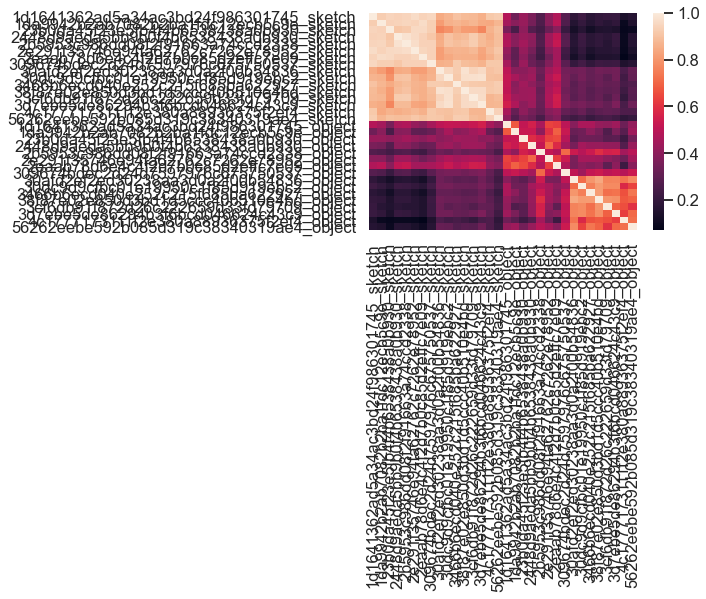

In [11]:
## correlation matrix
R = SO.loc[:,feat_cols].transpose().corr()
x_axis_labels = list(SO['shapenet_dtype'].values)
y_axis_labels = list(SO['shapenet_dtype'].values)

## draw heatmap
sns.heatmap(R, xticklabels=x_axis_labels, yticklabels=y_axis_labels)

### INDIRECT ANALYSIS (similarity between sketches of same object vs. different objects)

In [12]:
this_shapenetID = shapenetIDs[0]
these_sketch_feats = S[(S['shapenetID']==this_shapenetID) & (S['phase']=='pre')][feat_cols]

In [13]:
distance_matrix(these_sketch_feats, these_sketch_feats, p=2)

array([[ 0.        , 53.36346588, 45.26627087, ..., 34.06196215,
        50.2816151 , 53.71408812],
       [53.36346588,  0.        , 31.78486056, ..., 48.11723523,
        46.24174865, 36.46399485],
       [45.26627087, 31.78486056,  0.        , ..., 40.6576328 ,
        48.52436057, 42.50123373],
       ...,
       [34.06196215, 48.11723523, 40.6576328 , ...,  0.        ,
        48.60758426, 48.82329477],
       [50.2816151 , 46.24174865, 48.52436057, ..., 48.60758426,
         0.        , 33.12632491],
       [53.71408812, 36.46399485, 42.50123373, ..., 48.82329477,
        33.12632491,  0.        ]])

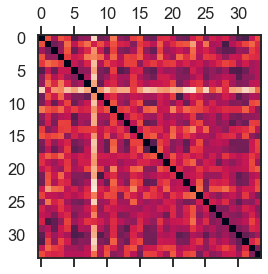

In [14]:
import scipy.spatial.distance as dist
R = dist.squareform(dist.pdist(these_sketch_feats, metric='correlation'))
plt.matshow(R)

/Users/judithfan/anaconda3/lib/python3.8/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


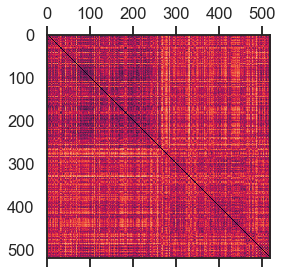

In [15]:
## pull out all drawings from a particular phase (both conditions, all participants)
S_ = S[S['phase']=='pre']
S_.sort_values(by =['shapenetID'],inplace=True)
S_ = S_.reset_index()

## subset columns to just those that are critical for setting up classifier
key_cols = ['shapenetID'] + list(feat_cols)
S_ = S_[key_cols]

## visualize the correlation distance matrix for all drawings of each object
these_sketch_feats = S_[feat_cols]
import scipy.spatial.distance as dist
R = dist.squareform(dist.pdist(these_sketch_feats, metric='correlation'))
plt.matshow(R)

#### OBJECT-LEVEL CLASSIFICATION ACCURACY 

In [39]:
# regularization_strength = [1e-6, 1e-5, 1e-4, 1e-3]
regularization_strength = 3e-4

In [40]:
## use standard sklearn notation to represent data and labels
X = np.array(S_[feat_cols])
y = np.array(S_['shapenetID'].values)

## construct stratified splits for cross-validated classification
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
skf.get_n_splits(X, y)

## march through each stratified train/test split and fit/evaluate object classification accuracy
from sklearn import linear_model
clf_acc = []
for train_index, test_index in skf.split(X, y):    
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    ## fit classifier
    clf = linear_model.LogisticRegression(penalty='l2',C=regularization_strength).fit(X_train, y_train)
    
    ## evaluate classifier
    cats = clf.classes_
    probs = clf.predict_proba(X_test)
    preds = clf.predict(X_test)
    acc = clf.score(X_test,y_test)
    
    ## append to list
    clf_acc.append(acc)

## print classifier accuracies
print('Per-split classification accuracy: {}'.format(clf_acc))
print('Mean crossvalidated classification accuracy: {}'.format( np.mean(clf_acc)))

Per-split classification accuracy: [0.2980769230769231, 0.41346153846153844, 0.2403846153846154, 0.3076923076923077, 0.375]
Mean crossvalidated classification accuracy: 0.3269230769230769


#### PERMUTATION TEST (estimate of classification accuracy for shuffled labels)

In [41]:
#### PERMUTATION TEST (SHUFFLE LABELS)
from numpy import random

## use standard sklearn notation to represent data and labels
X = np.array(S_[feat_cols])
y = np.array(S_['shapenetID'].values)
random.RandomState(seed=1).shuffle(y)

## construct stratified splits for cross-validated classification
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
skf.get_n_splits(X, y)

## march through each stratified train/test split and fit/evaluate object classification accuracy
from sklearn import linear_model
clf_acc = []
for train_index, test_index in skf.split(X, y):    
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    ## fit classifier
    clf = linear_model.LogisticRegression(penalty='l2',C=regularization_strength).fit(X_train, y_train)
    
    ## evaluate classifier
    cats = clf.classes_
    probs = clf.predict_proba(X_test)
    preds = clf.predict(X_test)
    acc = clf.score(X_test,y_test)
    
    ## append to list
    clf_acc.append(acc)

## print classifier accuracies
print('Per-split classification accuracy: {}'.format(clf_acc))
print('Mean crossvalidated classification accuracy: {}'.format(np.mean(clf_acc)))

Per-split classification accuracy: [0.08653846153846154, 0.04807692307692308, 0.08653846153846154, 0.04807692307692308, 0.038461538461538464]
Mean crossvalidated classification accuracy: 0.06153846153846154
